In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import xgboost as xg
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
price_data_full = pd.read_csv("price_features_final.csv")

In [3]:
price_data_full.head()

,Date,Hour,LMP,Energy_LMP,Loss_LMP,Congestion_LMP,TMP,GD Henry Hub,GD Houston ShipChl,GD Waha,...,Population,Z_GUADALAJARA,Z_MONTERREY,Z_VDM SUR,S_SPRING,S_SUMMER,S_WINTER,Year,Month,Day
0,2016-02-05,21,632.40,745.34,-74.92,-38.02,55.76,2.045,1.99,1.94,...,1036806,0,0,0,0,0,1,2016,2,5
1,2016-02-05,21,566.03,745.34,-58.33,-120.99,59.00,2.045,1.99,1.94,...,5341171,0,1,0,0,0,1,2016,2,5
2,2016-02-05,21,759.00,745.34,18.14,-4.49,73.94,2.045,1.99,1.94,...,21804515,0,0,1,0,0,1,2016,2,5
3,2016-02-06,3,519.41,598.45,-79.05,0.00,47.12,2.085,2.02,1.94,...,1036806,0,0,0,0,0,1,2016,2,6
4,2016-02-06,3,553.88,598.45,-44.58,0.00,57.56,2.085,2.02,1.94,...,5341171,0,1,0,0,0,1,2016,2,6


In [4]:
price_data_full['Date']= pd.to_datetime(price_data_full['Date'])
price_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37594 entries, 0 to 37593
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                37594 non-null  datetime64[ns]
 1   Hour                37594 non-null  int64         
 2   LMP                 37594 non-null  float64       
 3   Energy_LMP          37594 non-null  float64       
 4   Loss_LMP            37594 non-null  float64       
 5   Congestion_LMP      37594 non-null  float64       
 6   TMP                 37594 non-null  float64       
 7   GD Henry Hub        37594 non-null  float64       
 8   GD Houston ShipChl  37594 non-null  float64       
 9   GD Waha             37594 non-null  float64       
 10  TotalMWh            37594 non-null  float64       
 11  LATITUDE            37594 non-null  float64       
 12  LONGITUDE           37594 non-null  float64       
 13  HDD                 37594 non-null  float64   

In [5]:
price_data_full["DateTime"] = pd.to_datetime(price_data_full.Date) + price_data_full.Hour.astype('timedelta64[h]')

In [6]:
price_data_full.sort_values(by='DateTime', inplace = True)
price_data_full.reset_index(drop = True, inplace = True)
price_data_full.head()

,Date,Hour,LMP,Energy_LMP,Loss_LMP,Congestion_LMP,TMP,GD Henry Hub,GD Houston ShipChl,GD Waha,...,Z_GUADALAJARA,Z_MONTERREY,Z_VDM SUR,S_SPRING,S_SUMMER,S_WINTER,Year,Month,Day,DateTime
0,2016-01-29,3,497.98,512.81,-14.72,-0.11,58.64,2.12,2.105,2.0,...,0,1,0,0,0,1,2016,1,29,2016-01-29 03:00:00
1,2016-01-29,3,519.77,512.81,6.95,0.01,52.52,2.12,2.105,2.0,...,0,0,1,0,0,1,2016,1,29,2016-01-29 03:00:00
2,2016-01-29,3,493.40,512.81,-16.81,-2.60,46.40,2.12,2.105,2.0,...,0,0,0,0,0,1,2016,1,29,2016-01-29 03:00:00
3,2016-01-29,6,531.16,547.62,-16.32,-0.14,52.88,2.12,2.105,2.0,...,0,1,0,0,0,1,2016,1,29,2016-01-29 06:00:00
4,2016-01-29,6,520.00,547.61,-24.17,-3.44,43.16,2.12,2.105,2.0,...,0,0,0,0,0,1,2016,1,29,2016-01-29 06:00:00


In [7]:
price_data = price_data_full[(price_data_full['Z_GUADALAJARA'] == 1)]
price_data.reset_index(inplace = True, drop = True)

In [8]:
price_data.head()

,Date,Hour,LMP,Energy_LMP,Loss_LMP,Congestion_LMP,TMP,GD Henry Hub,GD Houston ShipChl,GD Waha,...,Z_GUADALAJARA,Z_MONTERREY,Z_VDM SUR,S_SPRING,S_SUMMER,S_WINTER,Year,Month,Day,DateTime
0,2016-01-29,15,872.39,838.90,33.52,-0.03,41.90,2.12,2.105,2.0,...,1,0,0,0,0,1,2016,1,29,2016-01-29 15:00:00
1,2016-01-29,18,879.99,846.88,32.87,0.23,62.96,2.12,2.105,2.0,...,1,0,0,0,0,1,2016,1,29,2016-01-29 18:00:00
2,2016-01-29,21,952.06,916.48,31.10,4.48,72.14,2.12,2.105,2.0,...,1,0,0,0,0,1,2016,1,29,2016-01-29 21:00:00
3,2016-01-30,18,921.31,891.79,29.52,0.00,72.50,2.12,2.105,2.0,...,1,0,0,0,0,1,2016,1,30,2016-01-30 18:00:00
4,2016-01-30,21,860.39,815.08,28.25,17.06,76.10,2.12,2.105,2.0,...,1,0,0,0,0,1,2016,1,30,2016-01-30 21:00:00


In [9]:
9108*.8

7286.400000000001

In [10]:
price_data.columns

Index(['Date', 'Hour', 'LMP', 'Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day', 'DateTime'],
      dtype='object')

In [11]:
prices = price_data
price_data = price_data.drop(['Date'], axis = 1)
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day'], axis = 1)

In [12]:
price_new.head()

,LMP,DateTime
0,872.39,2016-01-29 15:00:00
1,879.99,2016-01-29 18:00:00
2,952.06,2016-01-29 21:00:00
3,921.31,2016-01-30 18:00:00
4,860.39,2016-01-30 21:00:00


In [13]:
X = price_data.drop(['DateTime','LMP','Energy_LMP','Loss_LMP','Congestion_LMP','LATITUDE', 'LONGITUDE','Population','HDD','Year','Z_GUADALAJARA','Z_MONTERREY', 'Z_VDM SUR'], axis = 1)
y = price_data['LMP']

In [14]:
#len_data = 9108
#test_lowerlim = 7000
#test_upperlim = test_lowerlim + 48
#price_new = price_new[test_lowerlim:test_upperlim]
#X_train1= X[:test_lowerlim]
#X_train2 = X[test_upperlim:]
#X_train = pd.concat([X_train1,X_train2])
#X_test = X[test_lowerlim:test_upperlim]
#y_train1= y[:test_lowerlim]
#y_train2 = y[test_upperlim:]
#y_train = pd.concat([y_train1,y_train2])
#y_test = y[test_lowerlim:test_upperlim]

In [15]:
#X_train = X[:7000]
#y_train = y[:7000]
#X_test = X[7000:]
#y_test = y[7000:]
#price_new = price_new[7000:]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.2, 
                                                    random_state=42)

test_index = X_test.index

In [17]:
price_new = price_new.iloc[test_index]


# Scaling

In [18]:
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Extra Trees Regressor

### Base Model

In [19]:
etr = ensemble.ExtraTreesRegressor(n_estimators=400,random_state=42,max_depth=24,max_features='sqrt')
etr.fit(X_train, y_train) 
y_pred = etr.predict(X_test)
y_trainpred = etr.predict(X_train)

etr.score(X_test, y_test)

0.7427988354708082

###  RandomizedSearchCV

In [20]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,16,24,32,50],
        'min_samples_split':np.arange(2,15),
        'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'bootstrap':[True,False]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 16, 24, 32, 50],
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['auto', 'sqrt', 'log2'],
 'bootstrap': [True, False]}

In [21]:
etr = ensemble.ExtraTreesRegressor()
etr_rcv= RandomizedSearchCV(etr, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
etr_rcv.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_iter=150, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 16, 24, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [10, 12, 16, 20, 26, 33,
                                                         42, 54, 69, 88, 112,
                                                         143, 183, 233, 297,
                                                         379, 483, 615, 784,
                                                         1000]},
                   random_state=42)

In [22]:
print("Best Score:" + str(etr_rcv.best_score_))
print("Best Parameters: " + str(etr_rcv.best_params_))

Best Score:0.7128783808249266
Best Parameters: {'n_estimators': 143, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}


### GridSearchCV

In [23]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]
grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,10,24,36,50],
        'min_samples_split':np.arange(2,15,2),
}
grid_params

{'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359, 599, 1000],
 'max_depth': [2, 10, 24, 36, 50],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14])}

In [24]:
etr = ensemble.ExtraTreesRegressor()
etr_cv= GridSearchCV(etr, param_grid=grid_params, cv=5, n_jobs=-1)
etr_cv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 10, 24, 36, 50],
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359,
                                          599, 1000]})

In [25]:
print("Best Score:" + str(etr_cv.best_score_))
print("Best Parameters: " + str(etr_cv.best_params_))

Best Score:0.727542765666721
Best Parameters: {'max_depth': 36, 'min_samples_split': 2, 'n_estimators': 129}


### Model after tuning

In [26]:
etr = ensemble.ExtraTreesRegressor(n_estimators=400,random_state=42,max_depth=24,max_features='sqrt')
etr.fit(X_train, y_train) 
y_pred = etr.predict(X_test)
y_trainpred = etr.predict(X_train)

etr.score(X_test, y_test)

0.7427988354708082

In [27]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.24964759767371952
The rmse of train prediction is: 0.01736614901429406


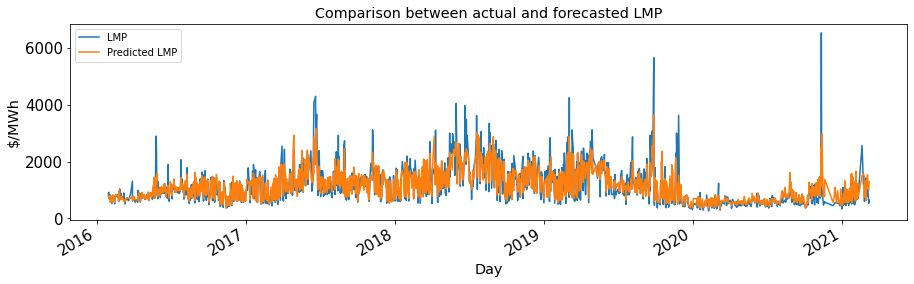

In [28]:
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [29]:
price_new

,LMP,Predicted LMP
DateTime,,
2016-09-02 15:00:00,1192.94,1269.431410
2017-03-08 18:00:00,1019.68,1244.045985
2021-01-10 03:00:00,512.02,560.704026
2018-11-20 06:00:00,1020.92,1127.421700
2020-02-07 18:00:00,434.89,697.894981
...,...,...
2017-05-24 09:00:00,1936.71,1958.694787
2019-09-27 18:00:00,5655.20,3648.380714
2017-03-21 03:00:00,494.26,643.050222


In [30]:
feature_importances = pd.DataFrame(etr.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [31]:
feature_importances

,importance
TotalMWh,0.229434
GD Henry Hub,0.183067
GD Houston ShipChl,0.167303
GD Waha,0.109286
Day,0.071933
TMP,0.053578
Month,0.052937
Hour,0.050400
CDD,0.041369
S_SUMMER,0.014879


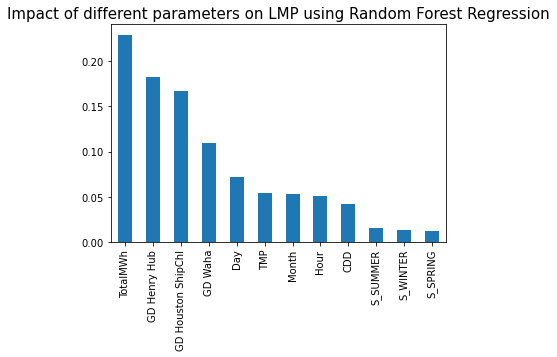

In [32]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Impact of different parameters on LMP using Random Forest Regression',fontsize=15)
plt.xticks(rotation = 90) 
plt.show()

# Random Forest Regressor

### Base Model

In [33]:
rfr = ensemble.RandomForestRegressor(random_state=42,n_estimators=100)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
y_trainpred = rfr.predict(X_train)

rfr.score(X_test, y_test)

0.7803570514351803

###  RandomizedSearchCV

In [34]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,16,24,32,50],
        'min_samples_split':np.arange(2,15),
        'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'bootstrap':[True,False]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 16, 24, 32, 50],
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['auto', 'sqrt', 'log2'],
 'bootstrap': [True, False]}

In [35]:
rfr = ensemble.RandomForestRegressor()
rfr_rcv= RandomizedSearchCV(rfr, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
rfr_rcv.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 16, 24, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [10, 12, 16, 20, 26, 33,
                                                         42, 54, 69, 88, 112,
                                                         143, 183, 233, 297,
                                                         379, 483, 615, 784,
                                                         1000]},
                   random_state=42)

In [36]:
print("Best Score:" + str(rfr_rcv.best_score_))
print("Best Parameters: " + str(rfr_rcv.best_params_))

Best Score:0.7575582655956569
Best Parameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 24, 'bootstrap': False}


### GridSearchCV

In [37]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]
grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,10,24,36,50],
        'min_samples_split':np.arange(2,15,2),
}
grid_params

{'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359, 599, 1000],
 'max_depth': [2, 10, 24, 36, 50],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14])}

In [38]:
rfr = ensemble.RandomForestRegressor()
rfr_cv= GridSearchCV(rfr, param_grid=grid_params, cv=5, n_jobs=-1)
rfr_cv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 10, 24, 36, 50],
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359,
                                          599, 1000]})

In [39]:
print("Best Score:" + str(rfr_cv.best_score_))
print("Best Parameters: " + str(rfr_cv.best_params_))

Best Score:0.7316499612973502
Best Parameters: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 129}


### Model after tuning

In [40]:
rfr = ensemble.RandomForestRegressor(random_state=42,n_estimators=100)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
y_trainpred = rfr.predict(X_train)

rfr.score(X_test, y_test)

0.7803570514351803

In [41]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.23070104330514274
The rmse of train prediction is: 0.09449970406936734


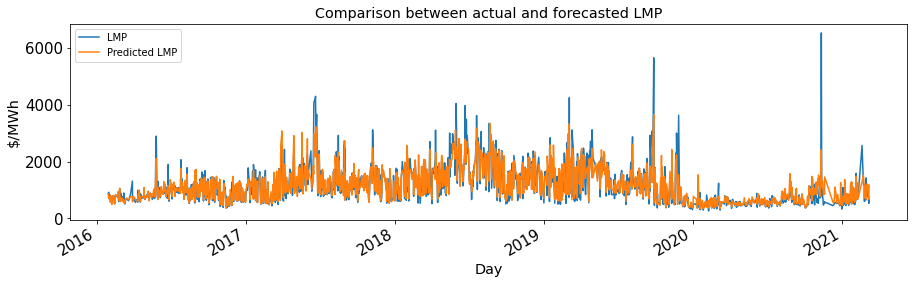

In [42]:
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day'], axis = 1)

#price_new = price_new[7000:]
#price_new = price_new[test_lowerlim:test_upperlim]
price_new = price_new.iloc[test_index]
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True,  figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [43]:
price_new

,LMP,Predicted LMP
DateTime,,
2016-09-02 15:00:00,1192.94,1273.6857
2017-03-08 18:00:00,1019.68,1202.6113
2021-01-10 03:00:00,512.02,542.4912
2018-11-20 06:00:00,1020.92,1050.0957
2020-02-07 18:00:00,434.89,606.2484
...,...,...
2017-05-24 09:00:00,1936.71,1865.8825
2019-09-27 18:00:00,5655.20,3654.8398
2017-03-21 03:00:00,494.26,592.6405


In [44]:
feature_importances = pd.DataFrame(etr.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [45]:
feature_importances

,importance
TotalMWh,0.229434
GD Henry Hub,0.183067
GD Houston ShipChl,0.167303
GD Waha,0.109286
Day,0.071933
TMP,0.053578
Month,0.052937
Hour,0.050400
CDD,0.041369
S_SUMMER,0.014879


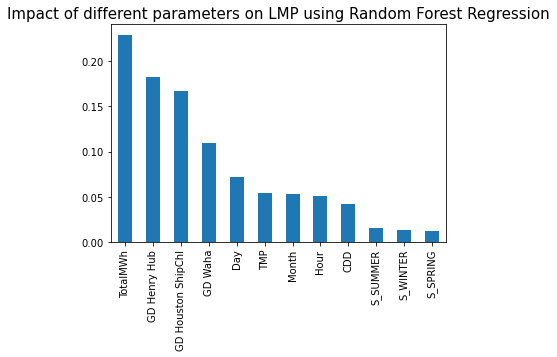

In [46]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Impact of different parameters on LMP using Random Forest Regression',fontsize=15)
plt.xticks(rotation = 90) 
plt.show()

# Gradient Boosting Regressor

### Base Model 

In [47]:
gbr = ensemble.GradientBoostingRegressor(max_depth=12, max_features='log2',
 n_estimators= 400, subsample= 0.95,learning_rate=0.01)
gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
y_trainpred = gbr.predict(X_train)

gbr.score(X_test, y_test)

0.799582917814342

###  RandomizedSearchCV 

In [48]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,12,16,24,32,50],
        'min_samples_split':np.arange(2,15),
        'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 12, 16, 24, 32, 50],
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['auto', 'sqrt', 'log2'],
 'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [49]:
gbr = ensemble.GradientBoostingRegressor(random_state=42)
gbr_rcv= RandomizedSearchCV(gbr, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
gbr_rcv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [2, 8, 12, 16, 24, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [10, 12, 16, 20, 26, 33,
                                                         42, 54, 69, 88, 112,
                                                         143, 183, 233, 297,
                                                         379, 483, 615, 784,


In [50]:
print("Best Score:" + str(gbr_rcv.best_score_))
print("Best Parameters: " + str(gbr_rcv.best_params_))

Best Score:0.7805009043196002
Best Parameters: {'subsample': 0.85, 'n_estimators': 784, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 24, 'learning_rate': 0.01}


### GridSearchCV

In [51]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,12,24,32,50],
        #'min_samples_split':np.arange(2,15),
        #'min_samples_leaf':[1,2,4],
        'max_features': ['auto', 'sqrt','log2'],
        'subsample':[0.7,0.8,0.9],
        'learning_rate':[0.0001, 0.01, 0.1, 0.3]
}
grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 12, 24, 32, 50],
 'max_features': ['auto', 'sqrt', 'log2'],
 'subsample': [0.7, 0.8, 0.9],
 'learning_rate': [0.0001, 0.01, 0.1, 0.3]}

In [52]:
gbr = ensemble.GradientBoostingRegressor()
gbr_cv= GridSearchCV(gbr, param_grid=grid_params, cv=5, n_jobs=-1)
gbr_cv.fit(X_train,y_train)


C:\Users\Zach Barrera\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.01, 0.1, 0.3],
                         'max_depth': [2, 12, 24, 32, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000],
                         'subsample': [0.7, 0.8, 0.9]})

In [53]:
print("Best Score:" + str(gbr_cv.best_score_))
print("Best Parameters: " + str(gbr_cv.best_params_))

Best Score:0.7772367176559125
Best Parameters: {'learning_rate': 0.01, 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 1000, 'subsample': 0.9}


### Model after tuning

In [54]:
gbr = ensemble.GradientBoostingRegressor(max_depth=12, max_features='log2',
 n_estimators= 400, subsample= 0.95,learning_rate=0.01)
gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
y_trainpred = gbr.predict(X_train)

gbr.score(X_test, y_test)

0.8014581704208726

In [55]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.2193395437509316
The rmse of train prediction is: 0.052687166419322015


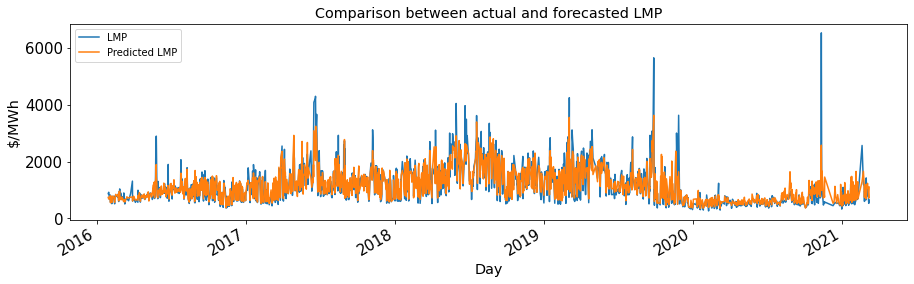

In [56]:
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day'], axis = 1)

#price_new = price_new[7000:]
#price_new = price_new[test_lowerlim:test_upperlim]
price_new = price_new.iloc[test_index]
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [57]:
price_new

,LMP,Predicted LMP
DateTime,,
2016-09-02 15:00:00,1192.94,1279.687512
2017-03-08 18:00:00,1019.68,1252.481723
2021-01-10 03:00:00,512.02,548.310925
2018-11-20 06:00:00,1020.92,1048.329821
2020-02-07 18:00:00,434.89,645.563963
...,...,...
2017-05-24 09:00:00,1936.71,1885.194698
2019-09-27 18:00:00,5655.20,3631.881099
2017-03-21 03:00:00,494.26,638.579360


In [58]:
feature_importances = pd.DataFrame(etr.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [59]:
feature_importances

,importance
TotalMWh,0.229434
GD Henry Hub,0.183067
GD Houston ShipChl,0.167303
GD Waha,0.109286
Day,0.071933
TMP,0.053578
Month,0.052937
Hour,0.050400
CDD,0.041369
S_SUMMER,0.014879


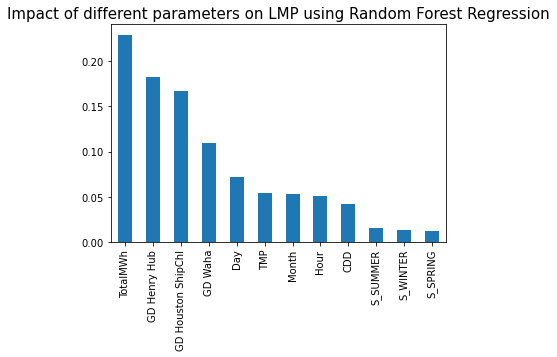

In [60]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Impact of different parameters on LMP using Random Forest Regression',fontsize=15)
plt.xticks(rotation = 90) 
plt.show()

# XGB Regressor

### Base Model

In [61]:
xgb =  xg.XGBRegressor(n_estimators=1400,
learning_rate=0.01,max_depth=17,gamma=5,subsample=0.85,
colsample_bytree = 0.85,min_child_weight=1)

xgb.fit(X_train, y_train) 
y_pred = xgb.predict(X_test)
y_trainpred = xgb.predict(X_train)

xgb.score(X_test, y_test)

0.8283478890809146

###  RandomizedSearchCV

In [62]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rcv_grid_params = {
        'n_estimators': n_est,
        'max_depth': [2,8,12,16,24,32,50],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'gamma':[i/10.0 for i in range(0,5)],
        'min_child_weight':range(1,6,2),
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}
rcv_grid_params

{'n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'max_depth': [2, 8, 12, 16, 24, 32, 50],
 'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'min_child_weight': range(1, 6, 2),
 'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [63]:
xgb = xg.XGBRegressor()
xgb_rcv= RandomizedSearchCV(xgb, param_distributions=rcv_grid_params, n_iter = 150, cv=5, random_state = 42, n_jobs=-1)
xgb_rcv.fit(X_train,y_train)

C:\Users\Zach Barrera\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   n_iter=150, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
     

In [64]:
print("Best Score:" + str(xgb_rcv.best_score_))
print("Best Parameters: " + str(xgb_rcv.best_params_))

Best Score:0.7931099499386426
Best Parameters: {'subsample': 0.9, 'n_estimators': 615, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.7}


### GridSearchCV

In [65]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]
grid_params = {
        'n_estimators': n_est,
        #'max_depth': [2,8,12,16,24,32,50],
        #'colsample_bytree':[i/10.0 for i in range(6,10)],
        'gamma':[i/10.0 for i in range(0,5)],
        #'min_child_weight':range(1,6,2),
        #'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}
grid_params

{'n_estimators': [10, 16, 27, 46, 77, 129, 215, 359, 599, 1000],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [66]:
xgb =  xg.XGBRegressor()
xgb_cv= GridSearchCV(xgb, param_grid=grid_params, cv=5, n_jobs=-1)
xgb_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [67]:
print("Best Score:" + str(xgb_cv.best_score_))
print("Best Parameters: " + str(xgb_cv.best_params_))

Best Score:0.7838323673725542
Best Parameters: {'gamma': 0.4, 'learning_rate': 0.1, 'n_estimators': 1000}


### Model after tuning

In [68]:
xgb =  xg.XGBRegressor(n_estimators=1400,
learning_rate=0.01,max_depth=17,gamma=5,subsample=0.85,
colsample_bytree = 0.85,min_child_weight=1)

xgb.fit(X_train, y_train) 
y_pred = xgb.predict(X_test)
y_trainpred = xgb.predict(X_train)

xgb.score(X_test, y_test)

0.8283478890809146

In [69]:
y_test1 = np.zeros(len(y_test))
y_train1 = np.zeros(len(y_train))

print('The rmse of test prediction is:', (mean_squared_error(y_test, y_pred)
/mean_squared_error(y_test, y_test1))** 0.5)
print('The rmse of train prediction is:', (mean_squared_error(y_train, y_trainpred)
/mean_squared_error(y_train, y_train1))** 0.5)

The rmse of test prediction is: 0.20394614479873907
The rmse of train prediction is: 0.0023048303528327113


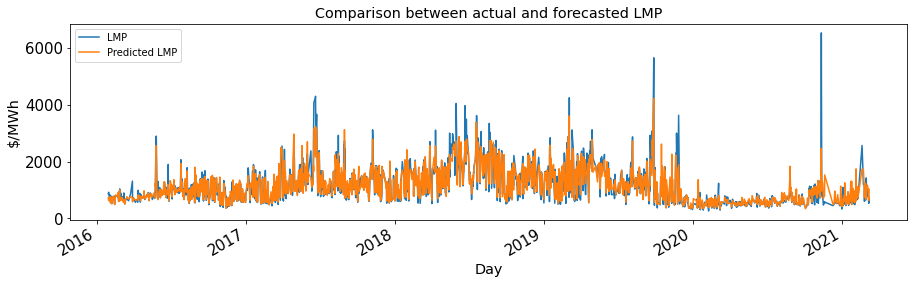

In [70]:
price_new = prices.drop(['Date','Hour','Energy_LMP', 'Loss_LMP', 'Congestion_LMP',
       'TMP', 'GD Henry Hub', 'GD Houston ShipChl', 'GD Waha', 'TotalMWh',
       'LATITUDE', 'LONGITUDE', 'HDD', 'CDD', 'Population', 'Z_GUADALAJARA',
       'Z_MONTERREY', 'Z_VDM SUR', 'S_SPRING', 'S_SUMMER', 'S_WINTER', 'Year',
       'Month', 'Day'], axis = 1)

#price_new = price_new[7000:]
#price_new = price_new[test_lowerlim:test_upperlim]
price_new = price_new.iloc[test_index]
price_new['Predicted LMP']= y_pred

price_new = price_new.set_index('DateTime')
price_new.plot(legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [71]:
price_new

,LMP,Predicted LMP
DateTime,,
2016-09-02 15:00:00,1192.94,1256.613159
2017-03-08 18:00:00,1019.68,1133.338867
2021-01-10 03:00:00,512.02,533.683105
2018-11-20 06:00:00,1020.92,1078.814209
2020-02-07 18:00:00,434.89,590.620239
...,...,...
2017-05-24 09:00:00,1936.71,1919.069458
2019-09-27 18:00:00,5655.20,4222.624512
2017-03-21 03:00:00,494.26,579.639771


In [72]:
feature_importances = pd.DataFrame(etr.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [73]:
feature_importances

,importance
TotalMWh,0.229434
GD Henry Hub,0.183067
GD Houston ShipChl,0.167303
GD Waha,0.109286
Day,0.071933
TMP,0.053578
Month,0.052937
Hour,0.050400
CDD,0.041369
S_SUMMER,0.014879


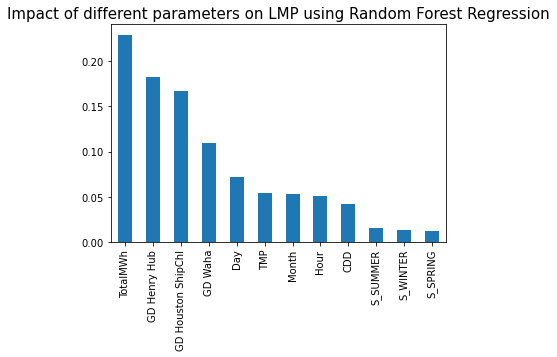

In [74]:
feature_importances.plot(kind='bar',rot=10,legend=False)
plt.title('Impact of different parameters on LMP using Random Forest Regression',fontsize=15)
plt.xticks(rotation = 90) 
plt.show()

In [75]:
price_new["residuals"] = price_new["Predicted LMP"] - price_new["LMP"]
price_new

,LMP,Predicted LMP,residuals
DateTime,,,
2016-09-02 15:00:00,1192.94,1256.613159,63.673159
2017-03-08 18:00:00,1019.68,1133.338867,113.658867
2021-01-10 03:00:00,512.02,533.683105,21.663105
2018-11-20 06:00:00,1020.92,1078.814209,57.894209
2020-02-07 18:00:00,434.89,590.620239,155.730239
...,...,...,...
2017-05-24 09:00:00,1936.71,1919.069458,-17.640542
2019-09-27 18:00:00,5655.20,4222.624512,-1432.575488
2017-03-21 03:00:00,494.26,579.639771,85.379771


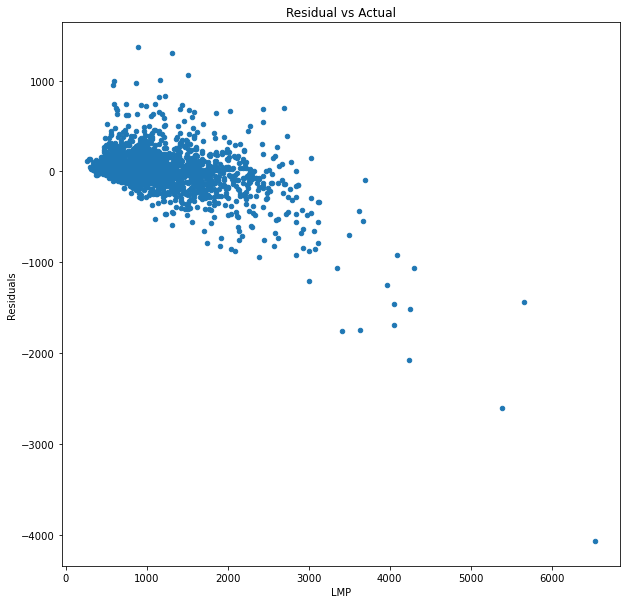

In [79]:
price_new.plot(x="LMP", y="residuals", kind = "scatter",figsize=(10,10))
plt.xlabel('LMP')
plt.ylabel('Residuals')
plt.title('Residual vs Actual')
plt.savefig('residualvactual.png')
plt.show()

In [80]:
price_new.sort_values(by='DateTime', inplace = True)
price_new

,LMP,Predicted LMP,residuals
DateTime,,,
2016-01-29 15:00:00,872.39,723.814636,-148.575364
2016-01-30 18:00:00,921.31,627.030579,-294.279421
2016-02-01 18:00:00,676.12,684.865845,8.745845
2016-02-02 15:00:00,822.85,732.182861,-90.667139
2016-02-03 15:00:00,821.98,764.455750,-57.524250
...,...,...,...
2021-03-02 21:00:00,781.93,1104.769043,322.839043
2021-03-04 18:00:00,1001.28,1167.859375,166.579375
2021-03-05 15:00:00,1009.48,1076.420166,66.940166


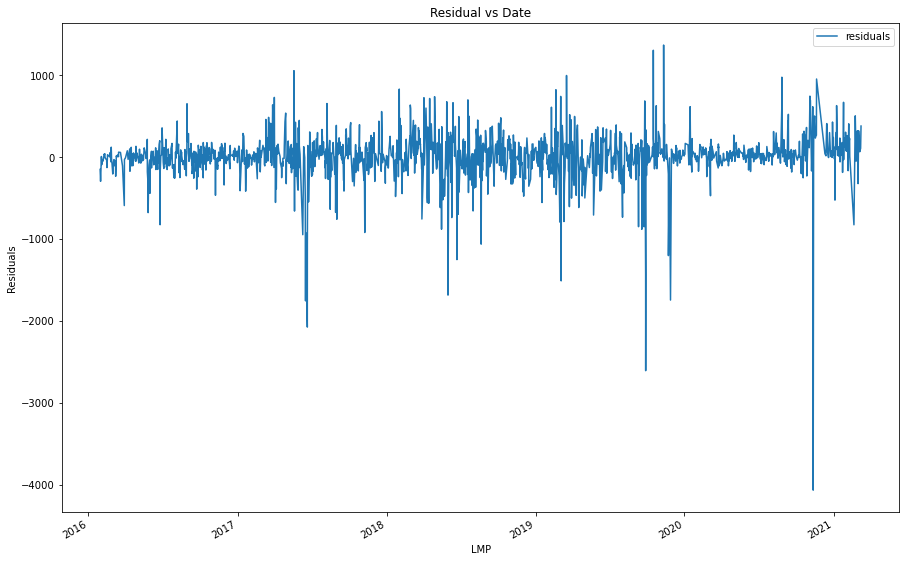

In [87]:
import matplotlib.dates as mdates
ax = price_new.plot(y="residuals",figsize=(15,10))
plt.xlabel('LMP')
plt.ylabel('Residuals')
plt.title('Residual vs Date')

plt.savefig('residualvdate.png')
plt.show()

In [89]:
price_new["abs_residuals"] = price_new["residuals"].abs()
price_new

,LMP,Predicted LMP,residuals,abs_residuals
DateTime,,,,
2016-01-29 15:00:00,872.39,723.814636,-148.575364,148.575364
2016-01-30 18:00:00,921.31,627.030579,-294.279421,294.279421
2016-02-01 18:00:00,676.12,684.865845,8.745845,8.745845
2016-02-02 15:00:00,822.85,732.182861,-90.667139,90.667139
2016-02-03 15:00:00,821.98,764.455750,-57.524250,57.524250
...,...,...,...,...
2021-03-02 21:00:00,781.93,1104.769043,322.839043,322.839043
2021-03-04 18:00:00,1001.28,1167.859375,166.579375,166.579375
2021-03-05 15:00:00,1009.48,1076.420166,66.940166,66.940166


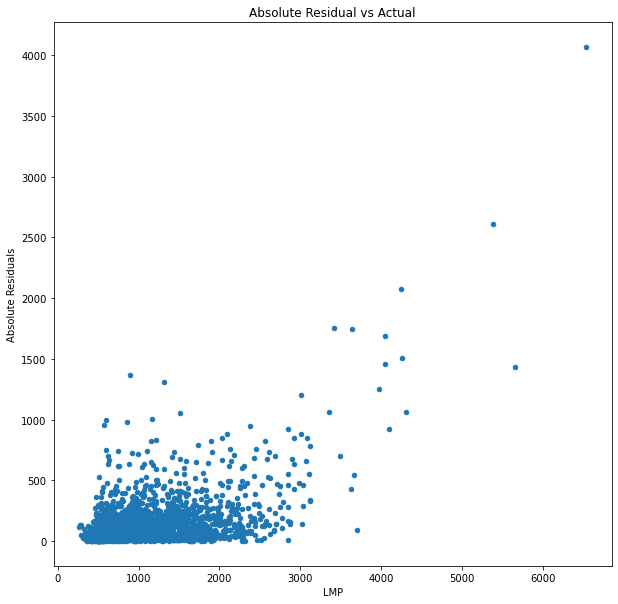

In [157]:
price_new.plot(x="LMP", y="abs_residuals", kind = "scatter",figsize=(10,10))
plt.xlabel('LMP')
plt.ylabel('Absolute Residuals')
plt.title('Absolute Residual vs Actual')
plt.savefig('absresidualvactual.png')
plt.show()

In [93]:
price_new.nlargest(20, 'abs_residuals')

,LMP,Predicted LMP,residuals,abs_residuals
DateTime,,,,
2020-11-11 12:00:00,6533.75,2465.633057,-4068.116943,4068.116943
2019-09-27 21:00:00,5383.52,2775.025146,-2608.494854,2608.494854
2017-06-20 12:00:00,4238.23,2162.739746,-2075.490254,2075.490254
2017-06-16 03:00:00,3411.06,1655.943359,-1755.116641,1755.116641
2019-11-27 18:00:00,3632.31,1886.722168,-1745.587832,1745.587832
2018-05-31 09:00:00,4047.95,2363.167236,-1684.782764,1684.782764
2019-03-04 18:00:00,4250.78,2739.998535,-1510.781465,1510.781465
2019-03-04 21:00:00,4048.60,2591.998535,-1456.601465,1456.601465
2019-09-27 18:00:00,5655.20,4222.624512,-1432.575488,1432.575488


<AxesSubplot:>

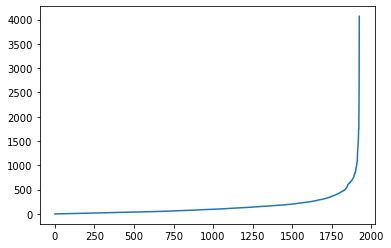

In [118]:
abs_res = price_new["abs_residuals"].sort_values().reset_index(drop = True)
abs_res.plot()

<AxesSubplot:>

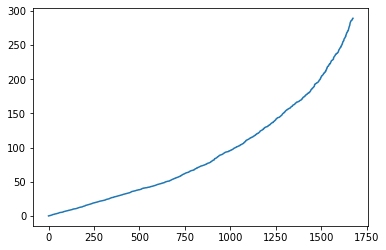

In [125]:
abs_res2 = abs_res.drop(abs_res.tail(250).index)
abs_res2.plot()

In [126]:
price_new.describe()

,LMP,Predicted LMP,residuals,abs_residuals
count,1925.000000,1925.000000,1925.000000,1925.000000
mean,1137.064540,1147.327637,10.263089,152.324837
std,643.198138,558.497375,266.285096,218.628046
min,264.990000,330.952393,-4068.116943,0.133918
25%,650.610000,707.536255,-63.741445,37.393262
50%,977.290000,1027.500366,22.113354,91.390125
75%,1458.480000,1476.494507,111.913677,184.374771
max,6533.750000,4222.624512,1370.965830,4068.116943


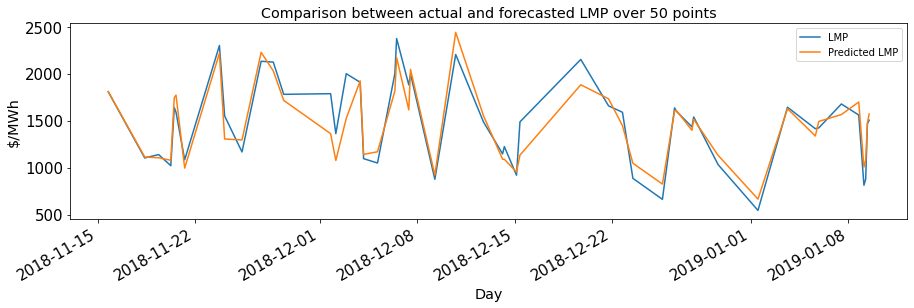

In [144]:
price_new_day = price_new[1100:1150]
price_new_day.plot(y = ["LMP","Predicted LMP"],legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP over 50 points',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

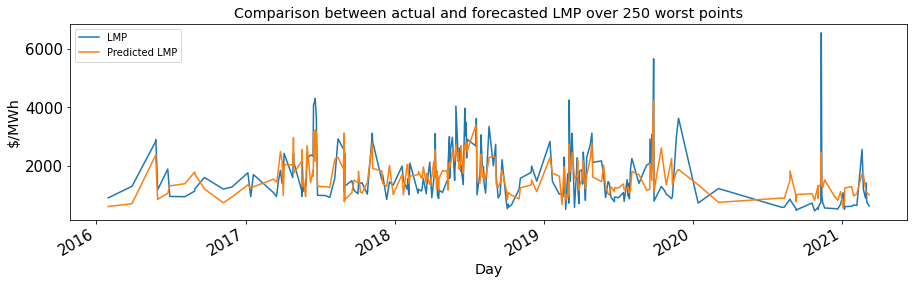

In [154]:
price_new_largestres = price_new.nlargest(250, 'abs_residuals')
price_new_largestres.plot(y = ["LMP","Predicted LMP"],legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP over 250 worst points',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

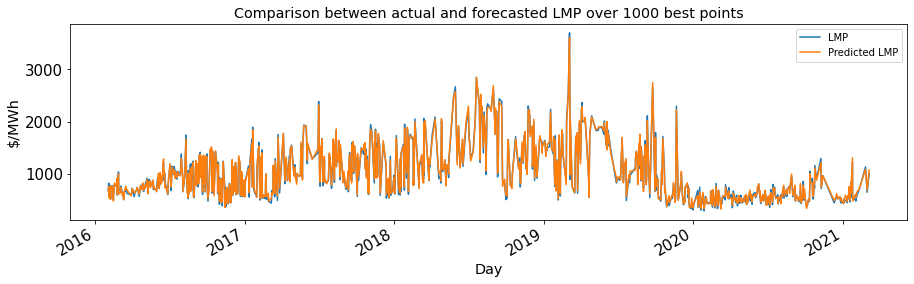

In [155]:
price_new_smallres = price_new.nsmallest(1000, 'abs_residuals')
price_new_smallres.plot(y = ["LMP","Predicted LMP"],legend=True, figsize=(15,4))
plt.xlabel('Day',fontsize='x-large')
plt.ylabel('$/MWh',fontsize='x-large')
plt.title('Comparison between actual and forecasted LMP over 1000 best points',fontsize='x-large')
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
